In [2]:
# llmscholar_plotting.py
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, Iterable, List, Optional, Sequence, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


CIType = Union[None, float, int, Sequence[float], Dict[str, float]]


def _as_float(x: Any) -> Optional[float]:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    try:
        return float(x)
    except Exception:
        return None


def _parse_ci_to_xerr(value: float, ci: CIType) -> Optional[np.ndarray]:
    """
    Convert a CI specification into matplotlib xerr format (2,).
    Supported:
      - None: no error bar
      - scalar: treated as half-width
      - (low, high): absolute bounds
      - {'low': .., 'high': ..} or {'ci_low': .., 'ci_high': ..}: absolute bounds
    """
    if ci is None:
        return None

    if isinstance(ci, (int, float, np.number)):
        hw = float(ci)
        if not np.isfinite(hw) or hw < 0:
            return None
        return np.array([hw, hw], dtype=float)

    if isinstance(ci, dict):
        low = ci.get("low", ci.get("ci_low", None))
        high = ci.get("high", ci.get("ci_high", None))
        low = _as_float(low)
        high = _as_float(high)
        if low is None or high is None:
            return None
        left = max(0.0, value - low)
        right = max(0.0, high - value)
        return np.array([left, right], dtype=float)

    if isinstance(ci, (list, tuple, np.ndarray)) and len(ci) == 2:
        low = _as_float(ci[0])
        high = _as_float(ci[1])
        if low is None or high is None:
            return None
        left = max(0.0, value - low)
        right = max(0.0, high - value)
        return np.array([left, right], dtype=float)

    return None


def _default_metric_colors(metrics: Sequence[str]) -> Dict[str, Any]:
    cycle = list(plt.rcParams["axes.prop_cycle"].by_key().get("color", []))
    if not cycle:
        cycle = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]
    return {m: cycle[i % len(cycle)] for i, m in enumerate(metrics)}


@dataclass(frozen=True)
class PanelPlotSpec:
    value_col: str = "value"
    ci_col: str = "ci"
    metric_col: str = "metric"
    task_filter: Optional[Dict[str, Any]] = None  # e.g., {"task_name": "twins", "task_param": "all"}


def plot_metric_panels(
    df: pd.DataFrame,
    *,
    metrics: Sequence[str],
    group_cols: Sequence[str],
    row_label_col: str,
    spec: PanelPlotSpec = PanelPlotSpec(),
    sort_within_groups: bool = False,
    sort_by: Optional[str] = None,
    ascending: bool = False,
    metric_titles: Optional[Dict[str, str]] = None,
    metric_order: Optional[Sequence[str]] = None,
    xlims: Optional[Dict[str, Tuple[float, float]]] = None,
    show_metric_xticks: bool = True,
    show_row_grid: bool = True,
    group_label_cols: Optional[Sequence[str]] = None,
    group_label_fontsize: int = 10,
    row_fontsize: int = 9,
    title_fontsize: int = 10,
    figsize: Tuple[float, float] = (16, 4.2),
    left_table_width: float = 0.26,
    wspace: float = 0.08,
    hspace: float = 0.0,
    bar_height: float = 0.62,
    error_kw: Optional[Dict[str, Any]] = None,
    colors: Optional[Dict[str, Any]] = None,
) -> plt.Figure:
    """
    Multi-panel horizontal bar plot, matching the structure of the reference figure.

    Data requirement (long format):
      - group_cols define the row hierarchy (1+ levels)
      - row_label_col is the most granular row label (for example: 'model')
      - spec.metric_col identifies metrics (one panel per metric)
      - spec.value_col is the point estimate
      - spec.ci_col is an uncertainty specification (see _parse_ci_to_xerr)

    Flexibility:
      - Any columns may be used for group_cols and row_label_col.
      - Any subset and ordering of metrics may be plotted.

    Returns:
      matplotlib Figure
    """
    d = df.copy()

    # Optional task filtering
    if spec.task_filter:
        for k, v in spec.task_filter.items():
            d = d[d[k] == v]

    required = list(group_cols) + [row_label_col, spec.metric_col, spec.value_col]
    missing = [c for c in required if c not in d.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    if spec.ci_col not in d.columns:
        d[spec.ci_col] = None

    # Metric selection and order
    metrics = list(metrics)
    if metric_order is not None:
        metric_order = [m for m in metric_order if m in metrics]
        metrics = metric_order
    d = d[d[spec.metric_col].isin(metrics)]

    # Aggregate duplicates if present (mean value, and keep first ci if identical; otherwise drop ci)
    keys = list(group_cols) + [row_label_col, spec.metric_col]
    if d.duplicated(keys).any():
        def _agg_ci(s: pd.Series) -> Any:
            vals = list(s.dropna())
            if len(vals) == 0:
                return None
            first = vals[0]
            if all(v == first for v in vals):
                return first
            return None

        d = (
            d.groupby(keys, as_index=False)
             .agg(**{
                 spec.value_col: (spec.value_col, "mean"),
                 spec.ci_col: (spec.ci_col, _agg_ci),
             })
        )

    # Build row order
    row_keys = list(group_cols) + [row_label_col]
    rows = d[row_keys].drop_duplicates()

    if sort_within_groups:
        if sort_by is None:
            sort_by = metrics[0]
        sub = d[d[spec.metric_col] == sort_by][row_keys + [spec.value_col]].copy()
        rows = rows.merge(sub, on=row_keys, how="left")
        rows["_sort_val"] = rows[spec.value_col].fillna(-np.inf if not ascending else np.inf)
        rows = rows.sort_values(list(group_cols) + ["_sort_val"], ascending=[True] * len(group_cols) + [ascending])
        rows = rows.drop(columns=["_sort_val"])
    else:
        rows = rows.sort_values(list(group_cols) + [row_label_col], kind="stable")

    rows = rows.reset_index(drop=True)
    n_rows = len(rows)
    y = np.arange(n_rows)

    # Map each row to y index for fast lookup
    row_to_y = {
        tuple(rows.loc[i, row_keys].tolist()): float(y[i])
        for i in range(n_rows)
    }

    # Colors
    if colors is None:
        colors = _default_metric_colors(metrics)

    if error_kw is None:
        error_kw = dict(ecolor="black", elinewidth=0.8, capsize=2)

    # Figure layout: left "table" axis + one axis per metric
    n_metrics = len(metrics)
    fig = plt.figure(figsize=figsize, constrained_layout=False)
    gs = GridSpec(
        1, n_metrics + 1,
        width_ratios=[left_table_width] + [1.0] * n_metrics,
        wspace=wspace, hspace=hspace, figure=fig
    )

    ax_tbl = fig.add_subplot(gs[0, 0])
    metric_axes = [fig.add_subplot(gs[0, i + 1], sharey=ax_tbl) for i in range(n_metrics)]

    # Common y settings
    ax_tbl.set_ylim(-0.5, n_rows - 0.5)
    ax_tbl.invert_yaxis()
    ax_tbl.axis("off")

    for ax in metric_axes:
        ax.set_ylim(-0.5, n_rows - 0.5)
        ax.invert_yaxis()
        ax.tick_params(axis="y", left=False, labelleft=False)
        if show_row_grid:
            ax.set_axisbelow(True)
            ax.yaxis.grid(True, linestyle="-", linewidth=0.4, alpha=0.35)

    # Left table content: headers and labels
    if group_label_cols is None:
        group_label_cols = list(group_cols)

    # Column positions inside the table axis (0..1 in axes coords)
    # group levels appear first, then the row label
    n_left_cols = len(group_label_cols) + 1
    x_positions = np.linspace(0.0, 1.0, n_left_cols + 1)[:-1] + (0.5 / n_left_cols)
    x_positions = x_positions.tolist()

    headers = list(group_label_cols) + [row_label_col]
    for x, h in zip(x_positions, headers):
        ax_tbl.text(x, -0.9, str(h), ha="center", va="bottom", fontsize=group_label_fontsize, fontweight="bold")

    # Row label text (granular)
    for i in range(n_rows):
        label = str(rows.loc[i, row_label_col])
        ax_tbl.text(x_positions[-1], y[i], label, ha="center", va="center", fontsize=row_fontsize)

    # Group labels: place at the center of each contiguous block for each group level
    for level_idx, gcol in enumerate(group_label_cols):
        # Determine blocks by scanning in row order
        vals = rows[gcol].astype(str).tolist()
        start = 0
        while start < n_rows:
            v = vals[start]
            end = start
            while end + 1 < n_rows and vals[end + 1] == v:
                end += 1
            yc = (y[start] + y[end]) / 2.0
            ax_tbl.text(
                x_positions[level_idx], yc, v,
                ha="center", va="center", fontsize=group_label_fontsize
            )
            start = end + 1

    # Draw separator lines between top-level groups (first group col)
    if len(group_cols) >= 1:
        top = group_cols[0]
        vals = rows[top].astype(str).tolist()
        for i in range(1, n_rows):
            if vals[i] != vals[i - 1]:
                for ax in [ax_tbl] + metric_axes:
                    ax.axhline(i - 0.5, color="black", linewidth=0.8, alpha=0.55)

    # Plot each metric panel
    metric_titles = metric_titles or {}
    for ax, m in zip(metric_axes, metrics):
        sub = d[d[spec.metric_col] == m]
        # build arrays aligned to row order
        xs = np.full(n_rows, np.nan, dtype=float)
        xerr = np.full((2, n_rows), np.nan, dtype=float)

        for _, r in sub.iterrows():
            key = tuple([r[c] for c in row_keys])
            yi = row_to_y.get(key, None)
            if yi is None:
                continue
            idx = int(round(yi))
            val = _as_float(r[spec.value_col])
            if val is None:
                continue
            xs[idx] = val
            err = _parse_ci_to_xerr(val, r[spec.ci_col])
            if err is not None and np.all(np.isfinite(err)):
                xerr[:, idx] = err

        ok = np.isfinite(xs)
        ax.barh(
            y[ok],
            xs[ok],
            height=bar_height,
            color=colors.get(m, "C0"),
            edgecolor="none",
            xerr=(xerr[:, ok] if np.isfinite(xerr[:, ok]).all(axis=0).any() else None),
            error_kw=error_kw,
        )

        # Numeric labels on bars
        for yi, xi in zip(y[ok], xs[ok]):
            ax.text(xi, yi, f"{xi:.2f}", va="center", ha="left", fontsize=8, clip_on=True)

        ax.set_title(metric_titles.get(m, m), fontsize=title_fontsize)

        if xlims and m in xlims:
            ax.set_xlim(*xlims[m])
        else:
            # conservative default for proportions
            if np.nanmax(xs) <= 1.05 and np.nanmin(xs) >= -0.05:
                ax.set_xlim(0.0, 1.0)

        if not show_metric_xticks:
            ax.set_xticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return fig


def facet_grid_metric_panels(
    df: pd.DataFrame,
    *,
    facet_col: str,
    facet_order: Optional[Sequence[Any]] = None,
    metrics: Sequence[str],
    group_cols: Sequence[str],
    row_label_col: str,
    spec: PanelPlotSpec = PanelPlotSpec(),
    ncols: int = 2,
    figsize_per_facet: Tuple[float, float] = (16, 4.2),
    **kwargs: Any,
) -> plt.Figure:
    """
    Grid wrapper: one metric-panels plot per facet level (for example: task_name or task_param).
    """
    if facet_col not in df.columns:
        raise ValueError(f"Missing facet column: {facet_col}")

    levels = list(pd.unique(df[facet_col]))
    if facet_order is not None:
        levels = [x for x in facet_order if x in levels]

    n = len(levels)
    nrows = int(np.ceil(n / ncols))

    fig = plt.figure(figsize=(figsize_per_facet[0] * ncols, figsize_per_facet[1] * nrows))
    outer = GridSpec(nrows, ncols, figure=fig, wspace=0.15, hspace=0.25)

    for i, lvl in enumerate(levels):
        r = i // ncols
        c = i % ncols
        subfig = fig.add_subfigure(outer[r, c])
        ax_title = subfig.add_subplot(111)
        ax_title.axis("off")
        ax_title.set_title(f"{facet_col} = {lvl}", loc="left", fontsize=11, fontweight="bold")

        sub = df[df[facet_col] == lvl]
        # create an inset subfigure for the actual plot to keep the title clean
        inner = subfig.add_subfigure(outer[r, c])
        _ = plot_metric_panels(
            sub,
            metrics=metrics,
            group_cols=group_cols,
            row_label_col=row_label_col,
            spec=spec,
            **kwargs,
        )

    return fig


In [3]:
import pandas as pd
import numpy as np

toy_df = pd.DataFrame(
    [
        # Access
        ("open", "Open", "LLaMA-3-8B", "twins", "all", "validity", 0.83, (0.80, 0.86)),
        ("open", "Open", "LLaMA-3-8B", "twins", "all", "refusal", 0.10, (0.07, 0.13)),
        ("open", "Open", "LLaMA-3-8B", "twins", "all", "duplicate", 0.03, (0.01, 0.05)),
        ("open", "Open", "LLaMA-3-8B", "twins", "all", "factuality", 0.81, (0.78, 0.84)),
        ("open", "Open", "LLaMA-3-8B", "twins", "all", "connectedness", 0.89, (0.86, 0.92)),
        ("open", "Open", "LLaMA-3-8B", "twins", "all", "diversity", 0.69, (0.65, 0.73)),
        ("open", "Open", "LLaMA-3-8B", "twins", "all", "parity", 0.72, (0.68, 0.76)),

        ("proprietary", "Proprietary", "GPT-4.1", "twins", "all", "validity", 0.88, (0.85, 0.91)),
        ("proprietary", "Proprietary", "GPT-4.1", "twins", "all", "refusal", 0.16, (0.13, 0.19)),
        ("proprietary", "Proprietary", "GPT-4.1", "twins", "all", "duplicate", 0.01, (0.00, 0.02)),
        ("proprietary", "Proprietary", "GPT-4.1", "twins", "all", "factuality", 0.90, (0.88, 0.92)),
        ("proprietary", "Proprietary", "GPT-4.1", "twins", "all", "connectedness", 0.88, (0.85, 0.91)),
        ("proprietary", "Proprietary", "GPT-4.1", "twins", "all", "diversity", 0.68, (0.64, 0.72)),
        ("proprietary", "Proprietary", "GPT-4.1", "twins", "all", "parity", 0.71, (0.67, 0.75)),

        # Reasoning
        ("proprietary", "Reasoning", "o4-mini", "twins", "all", "validity", 0.67, (0.63, 0.71)),
        ("proprietary", "Reasoning", "o4-mini", "twins", "all", "refusal", 0.18, (0.15, 0.21)),
        ("proprietary", "Reasoning", "o4-mini", "twins", "all", "duplicate", 0.03, (0.01, 0.05)),
        ("proprietary", "Reasoning", "o4-mini", "twins", "all", "factuality", 0.87, (0.84, 0.90)),
        ("proprietary", "Reasoning", "o4-mini", "twins", "all", "connectedness", 0.86, (0.83, 0.89)),
        ("proprietary", "Reasoning", "o4-mini", "twins", "all", "diversity", 0.69, (0.65, 0.73)),
        ("proprietary", "Reasoning", "o4-mini", "twins", "all", "parity", 0.72, (0.68, 0.76)),
    ],
    columns=[
        "model_class",     # top-level group
        "model_group",     # second-level group
        "model",           # row label
        "task_name",
        "task_param",
        "metric",
        "value",           # point estimate
        "ci",              # confidence interval
    ],
)

toy_df


,model_class,model_group,model,task_name,task_param,metric,value,ci
0,open,Open,LLaMA-3-8B,twins,all,validity,0.83,"(0.8, 0.86)"
1,open,Open,LLaMA-3-8B,twins,all,refusal,0.10,"(0.07, 0.13)"
2,open,Open,LLaMA-3-8B,twins,all,duplicate,0.03,"(0.01, 0.05)"
3,open,Open,LLaMA-3-8B,twins,all,factuality,0.81,"(0.78, 0.84)"
4,open,Open,LLaMA-3-8B,twins,all,connectedness,0.89,"(0.86, 0.92)"
5,open,Open,LLaMA-3-8B,twins,all,diversity,0.69,"(0.65, 0.73)"
6,open,Open,LLaMA-3-8B,twins,all,parity,0.72,"(0.68, 0.76)"
7,proprietary,Proprietary,GPT-4.1,twins,all,validity,0.88,"(0.85, 0.91)"
8,proprietary,Proprietary,GPT-4.1,twins,all,refusal,0.16,"(0.13, 0.19)"
9,proprietary,Proprietary,GPT-4.1,twins,all,duplicate,0.01,"(0.0, 0.02)"


/tmp/ipykernel_1813485/589652328.py:312: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(xs) <= 1.05 and np.nanmin(xs) >= -0.05:


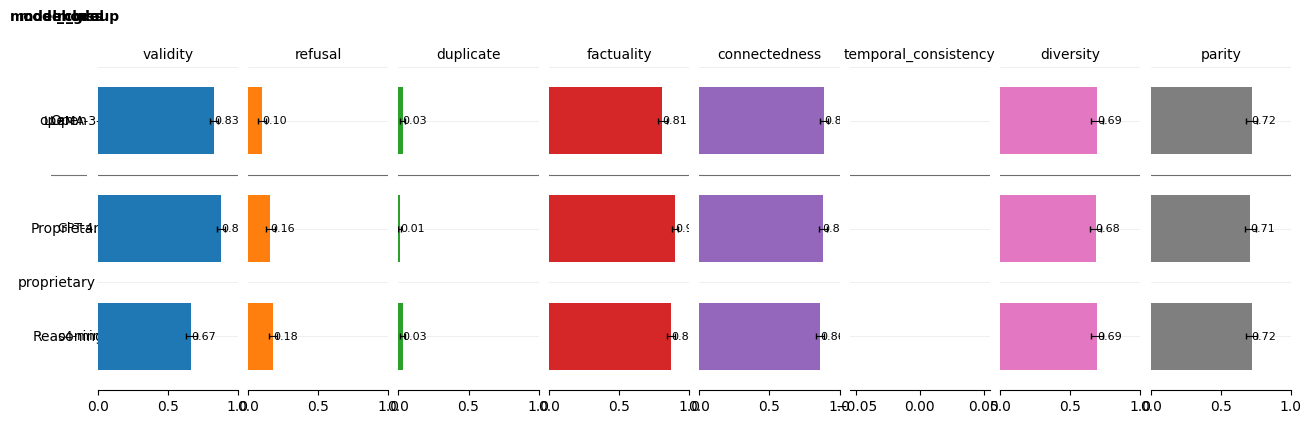

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
# from llmscholar_plotting import plot_metric_panels, PanelPlotSpec

# df columns: model_class, model_group, model, task_name, task_param, metric, value, ci
spec = PanelPlotSpec(value_col="value", ci_col="ci", metric_col="metric",
                     task_filter={"task_name": "twins", "task_param": "all"})

fig = plot_metric_panels(
    toy_df,
    metrics=["validity", "refusal", "duplicate", "factuality", "connectedness", "temporal_consistency", "diversity", "parity"],
    group_cols=["model_class", "model_group"],
    row_label_col="model",
    spec=spec,
    sort_within_groups=True,
    sort_by="validity",
)
plt.show()
